In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Working on %s' % (device))

Working on cuda:0


In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)

Files already downloaded and verified


In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)

In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

In [9]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

truck  frog  frog   car


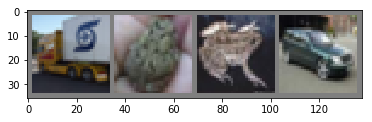

In [10]:
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
net = Net()
net = net.to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [19]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    t_0 = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            t_1 = time.time()
            print('[%d, %5d] loss: %.3f time: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000, t_1-t_0))
            t_0 = time.time()
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.181 time: 8.543
[1,  4000] loss: 1.865 time: 8.083
[1,  6000] loss: 1.668 time: 8.172
[1,  8000] loss: 1.581 time: 8.297
[1, 10000] loss: 1.511 time: 7.784
[1, 12000] loss: 1.452 time: 8.298
[2,  2000] loss: 1.402 time: 8.290
[2,  4000] loss: 1.377 time: 8.225
[2,  6000] loss: 1.322 time: 8.433
[2,  8000] loss: 1.315 time: 8.409
[2, 10000] loss: 1.267 time: 8.480
[2, 12000] loss: 1.251 time: 7.834
Finished Training


In [20]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


In [21]:
dataiter = iter(testloader)
images, labels = dataiter.next()

GroundTruth:    cat  ship  ship plane


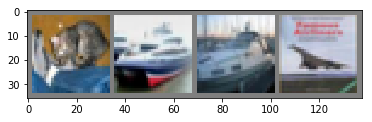

In [22]:
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [23]:
images = images.to(device)

In [24]:
outputs = net(images)

In [25]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                             for j in range(4)))

Predicted:   frog  ship  ship  ship


In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [27]:
print('Acc of the net on the 10k test imgs: %d %%' % (100 * correct / total))

Acc of the net on the 10k test imgs: 55 %


In [28]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [29]:
for i in range(10):
    print('Acc of %5s: %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Acc of plane: 70 %
Acc of   car: 56 %
Acc of  bird: 41 %
Acc of   cat: 17 %
Acc of  deer: 50 %
Acc of   dog: 52 %
Acc of  frog: 71 %
Acc of horse: 64 %
Acc of  ship: 81 %
Acc of truck: 55 %
